# Lecture 15 - Mechanistic modeling

In this lecture you learned about using ordinary differential equations (ODEs) to build mechanistic models of biological systems. In this tutorial we will build a simple model and use it to run simulations.

## Exercise 0: warm-up

Let's say we have two very simple chemical reactions: 
 - $R_1: A \to B$ with the kinetic rate: $r_1 = k_1 A$
 - $R_2: B \to C$ with the kinetic rate: $r_2 = k_2 B$
 
This leads to the following ODE model:

 - $\frac{dA}{dt} = -r_1$ 
 - $\frac{dB}{dt} = r_1 - r_2$
 - $\frac{dC}{dt} = r_2$ 
 
Let's say the initial concentrations are [A] = 10 mM, [B] = 0 mM, [C] = 0 mM, and the parameter values are $k_1 = 0.1 s^{-1}, k_2 = 0.05 s^{-1}$.

We can implement the model as follows:

In [4]:
def ode(t, X):
    
    # unpack the values from vector X
    a, b, c = X 
    
    # define the parameter values
    k1, k2 = 0.1, 0.05 
    
    # calculate the reaction rates
    r1 = k1 * a
    r2 = k2 * b
    
    # calculate the derivatives
    da = -r1
    db = r1 - r2
    dc = r2
    
    # return the derivatives as a single vector
    dX = [da, db, dc]
    return dX

X0 = [10, 0, 0]

We can now use function [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) to simulate the system by integrating the ODE over a given time span. 

> You will notice that we defined time (`t`) as an argument in the ODE function. 
> That's because *solve_ivp* is expecting a function with a signature `dX/dt = f(t, X)`. 
> We could use it to model events that depend explicitly on time. 

In [5]:
from scipy.integrate import solve_ivp

time_span = [0, 100] 

solution = solve_ivp(ode, time_span, X0)

Let's plot the simulation to see what it looks like:

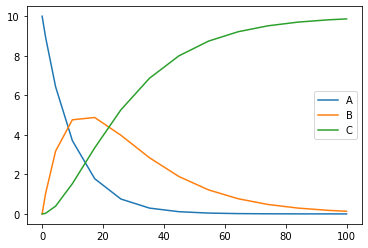

In [7]:
import matplotlib.pyplot as plt

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2])
plt.legend(['A', 'B', 'C'])

You will notice that the curves are not that smooth. We can try a different integration method:

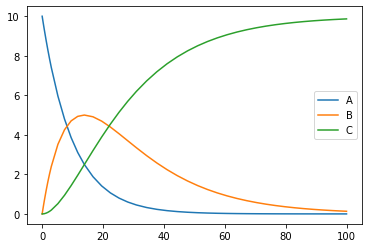

In [15]:
solution = solve_ivp(ode, time_span, X0, method='BDF')

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2])
plt.legend(['A', 'B', 'C'])

Ok, that looks better. But now we would like to see how changing the parameters would affect the solutions. 

Unfortunetely, we have *hard-coded* the parameter values inside the ODE function. We should instead make them arguments of the equation:

In [39]:
def ode(t, X, k1, k2):
    
    # unpack the values from vector X
    a, b, c = X 
    
    # calculate the reaction rates
    r1 = k1 * a
    r2 = k2 * b
    
    # calculate the derivatives
    da = -r1
    db = r1 - r2
    dc = r2
    
    # return the derivatives as a single vector
    dX = [da, db, dc]
    return dX

Now we can run a simulation with different parameter values:

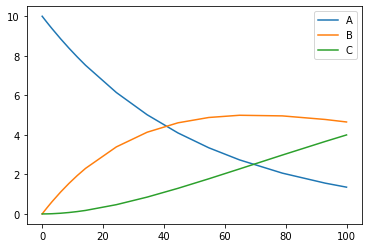

In [40]:
k1, k2 = 0.02, 0.01

solution = solve_ivp(ode, time_span, X0, method='BDF', args=(k1, k2))

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2])
plt.legend(['A', 'B', 'C'])

Perfect, now we are warmed-up!

## Exercise 1:

We will now model a more complex example. Consider the following toy model of a cell:

![toy model](files/toy_model.png)

The kinetic equations are as follows:

- $r_1 = k_1$
- $r_2 = V_2\frac{A}{K_2 + A}\frac{K_I}{K_I + C}$
- $r_3 = V_3\frac{A}{K_3 + A}$
- $r_4 = k_f B - k_r D$
- $r_5 = V_5\frac{B}{K_5 + B}$
- $r_6 = k_6 C$
- $r_7 = k_7 D$

And the parameter values are:

| parameter | value | units || parameter | value | units |
| --- | --- | --- | --- | --- | --- | --- |
| $k_1$ | 5 | mM/s || $k_f$ | 0.01 | 1/s |
| $V_2$ | 30 | mM/s || $k_r$ | 0.02 | 1/s |
| $K_2$ | 1 | mM || $V_5$ | 10 | mM/s |
| $K_I$ | 1 | mM || $K_5$ | 5 | mM |
| $V_3$ | 10 | mM/s || $k_6$ | 0.5 | 1/s |
| $K_3$ | 5 | mM || $k_7$ | 0.5 | 1/s |

### Exercise 1.1: 

Implement the model above as an ODE function. To speed thing up it is already partially written, just complete the code below:

> Note: We will keep only one parameter ($K_I$) as argument, the rest will be constant.

In [ ]:
def model(t, X, KI=1):

    # unpack values
    A, B, C, D = X

    # define parameters
    k1 = 5
    V2 = 30
    K2 = 1
    V3 = 10
    K3 = 5
    kf = 
    kr = 
    V5 = 
    K5 = 
    k6 = 
    k7 = 

    # kinetic rates
    r1 = k1
    r2 = V2 * (A / (K2 + A)) * (KI / (KI + C))
    r3 = V3 * (A / (K3 + A))
    r4 = 
    r5 = 
    r6 = 
    r7 = 
    
    # mass balance equations
    dA = r1 - r2 - r3
    dB = r2 - r4 - r5
    dC = 
    dD = 
    
    return [dA, dB, dC, dD]

Click below to see solution:

In [131]:
def model(t, X, KI=1):

    A, B, C, D = X

    k1 = 5
    V2 = 30
    K2 = 1
    V3 = 10
    K3 = 5
    kf = 0.01
    kr = 0.02
    V5 = 10
    K5 = 5
    k6 = 0.5
    k7 = 0.5

    r1 = k1
    r2 = V2 * (A / (K2 + A)) * (KI / (KI + C))
    r3 = V3 * (A / (K3 + A))
    r4 = kf * B - kr * D
    r5 = V5 * (B / (K5 + B))
    r6 = k6 * C
    r7 = k7 * D
    
    dA = r1 - r2 - r3
    dB = r2 - r4 - r5
    dC = r5 - r6
    dD = r3 + r4 - r7
    
    return [dA, dB, dC, dD]

## Exercise 1.2

Now run (and plot) a simulation using the model defined above:
    
- With initial concentrations of all compounds of 1 mM.
- For a time span of 10 seconds.

In [ ]:
# Type your code here...

Click below to see solution:

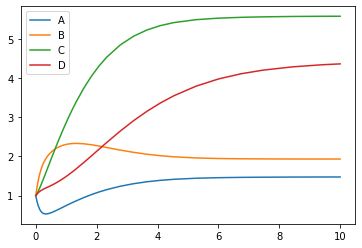

In [135]:
X0 = [1, 1, 1, 1]
time_span = [0, 10]

solution = solve_ivp(model, time_span, X0, method='BDF')

plt.plot(solution.t, solution.y[0],
         solution.t, solution.y[1],
         solution.t, solution.y[2],
         solution.t, solution.y[3])

plt.legend(['A', 'B', 'C', 'D'])

### Exercise 1.3

If everything went well, you will see that **C** accumulates faster than the other compounds. 
Going back to the diagram you can see that there is a regulatory feedback loop from **C** to **R2** to prevent accumulation in that pathway. This is controlled by the term ($K_I/(K_I + C)$) in rate *r2*.

The inhibition constant $K_I$ (mM) represents the affinity of the inhibitor to the enzyme. The lower the value, the higher the affinity, and the stronger the inhibition should be.

Let's test the final concentration of **C** (at 10 sec) with different affinity constants:

- Run a series of simulations for different values of $K_I$ (0.001, 0.01, 0.1, 1, 10, 100, 1000)
- Plot the final concentration of **C** as a function of $K_I$

> Note: the solution object from solve_ivp contains a matrix (*y*) with format: num variables vs num time points. You can use `solution.y[2,-1]` to get the final value of *C*.

In [ ]:
# type your code here...

Click below to see solution:

Text(0, 0.5, 'C')

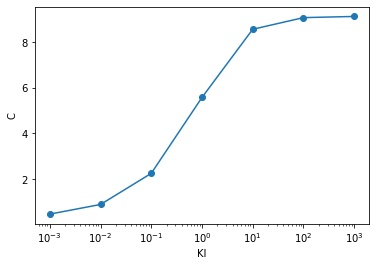

In [151]:
KIs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_final = []

for ki in KIs:
    solution = solve_ivp(model, [0, 10], X0, args=[ki], method='BDF')
    C_final.append(solution.y[2,-1])
    
plt.semilogx(KIs, C_final, 'o-')
plt.xlabel('KI')
plt.ylabel('C')

## Exercise 2

Now let's learn how we can use experimental data to calibrate a model using parameter estimation

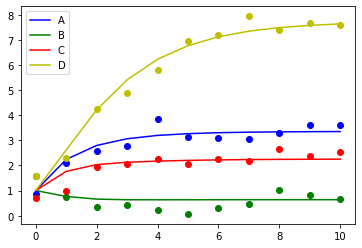

In [189]:
X0 = [1, 1, 1, 1]
time_span = [0, 10]

solution = solve_ivp(model, time_span, X0, method='BDF', args=[0.1], t_eval=list(range(11)))

plt.plot(solution.t, solution.y[0], 'b',
         solution.t, solution.y[1], 'g',
         solution.t, solution.y[2], 'r',
         solution.t, solution.y[3], 'y')

data = solution.y + 0.3*randn(*solution.y.shape)

plt.plot(solution.t, data[0], 'bo',
         solution.t, data[1], 'go',
         solution.t, data[2], 'ro',
         solution.t, data[3], 'yo')

plt.legend(['A', 'B', 'C', 'D'])

In [190]:
data

array([[0.86042602, 2.09825569, 2.59320639, 2.76017501, 3.85083535,
        3.140108  , 3.08243544, 3.06890244, 3.27605305, 3.61762287,
        3.62481152],
       [1.59781785, 0.76016235, 0.32767047, 0.4250193 , 0.21522499,
        0.06951418, 0.29687498, 0.44821461, 1.03846875, 0.84053488,
        0.65682657],
       [0.70090815, 0.97001426, 1.94062483, 2.04012535, 2.24414405,
        2.06230121, 2.25192638, 2.19329446, 2.67421281, 2.39647038,
        2.5398456 ],
       [1.57903985, 2.30842928, 4.25474175, 4.87445105, 5.78840341,
        6.95634528, 7.18079637, 7.94810056, 7.40299468, 7.66860436,
        7.6080199 ]])

In [176]:
data.shape

(4, 28)